In [1]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
datapath = 'C:/Users/THOMAS/Desktop/master_thesis_2020/code/image_sequences/0W100C1B'
#prefix = 'V1.75f3.125000'


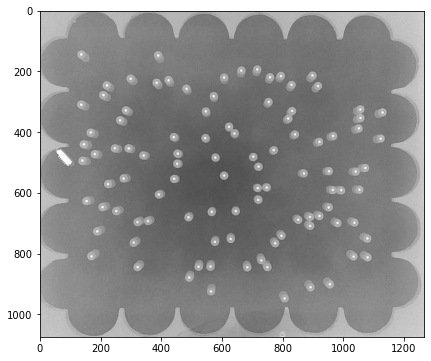

In [5]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

id_example = 0
rawframes = pims.open(os.path.join(datapath,'*.png'))

plt.imshow(rawframes[id_example]);


In [6]:
@pims.pipeline
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 45
    x_max = -35
    y_min = 100
    y_max = -300 
    return img[y_min:y_max,x_min:x_max]

#rawframes = crop(pims.open(os.path.join(datapath, '*.png')))
#plt.imshow(rawframes[id_example]);

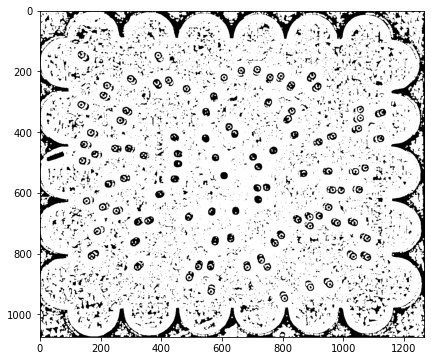

In [154]:
from scipy import ndimage
from skimage import morphology, util, filters


@pims.pipeline
def preprocess_bugs(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    #img = crop(img)
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img,53)
    idx = img > adaptive_thresh
    idx2 = img < adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


frames = preprocess_bugs(gray(pims.open(os.path.join(datapath, '*.png'))))

plt.imshow(frames[id_example+10]);

Found 5017 features
802
877


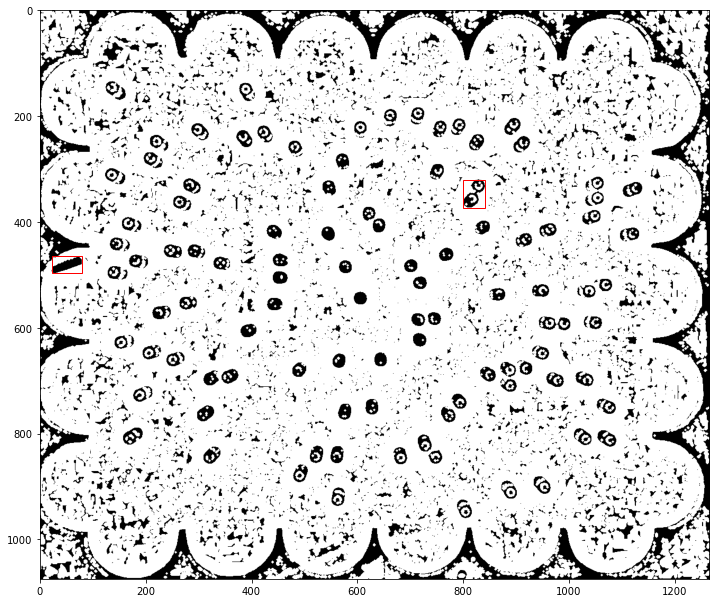

In [215]:
import skimage
import matplotlib.patches as mpatches

img_example = frames[id_example+10]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    
    if region.area < 720 or region.area > 950:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshhold
    if region.centroid[0] < 260 and region.area < 920:
        continue
    # Draw rectangle which survived to the criterions
    print(region.area)
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)


In [81]:
features = pd.DataFrame()
for num, img in enumerate(frames[0:10]):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    for region in skimage.measure.regionprops(label_image, intensity_image=img):
        # Everywhere, skip small and large areas
        
        if region.area < 900 or region.area > 940:
            continue
        # Only black areas
        if region.mean_intensity > 1:
            continue
        # On the top, skip small area with a second threshold
        if region.centroid[0] < 260 and region.area < 80: 
            continue
        # Store features which survived to the criterions
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'frame': num,
                                     },])

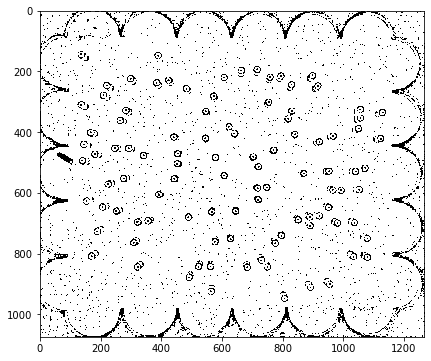

<AxesSubplot:>

In [85]:
tp.annotate(features[features.frame==(id_example+11)], img_example)